# Testing Binary Structure Models on Multivariate Data

Much of this notebook is adapted from notebooks/bivariate-categorical/03_meta_learning.ipynb

In [42]:
import sys
sys.path.insert(0, '../..')

In [43]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import trange as tnrange

from cs330.data_generators.multivariate_categorical import MultiCategorical
from cs330.data_generators.causal_graph import CausalGraph
from cs330.models.augmented_binary_models import *

#from models import StructuralModel

In [44]:
# Trial Setup
if False:
    TRIAL_ID = "binary_with_confounder"
    N = 10
    M = 3

    # Create graph and data generator
    data_gen = MultiCategorical(N, M)
    data_gen.graph.B = np.array([
        [0, 0, 0],
        [1, 0, 0],
        [1, 0, 0]
    ])
    # Determine node indices to compare
    A = 1
    B = 2

if True:
    TRIAL_ID = "binary_with_collider"
    N = 10
    M = 3

    # Create graph and data generator
    data_gen = MultiCategorical(N, M)
    data_gen.graph.B = np.array([
        [0, 0, 0],
        [0, 0, 0],
        [1, 1, 0]
    ])
    # Determine node indices to compare
    A = 0
    B = 1

In [45]:
# Create Model
# model = StructuralModel(N, dtype=torch.float64)
model = CauseOnlyBinaryStructureModel(N, M, A, B)

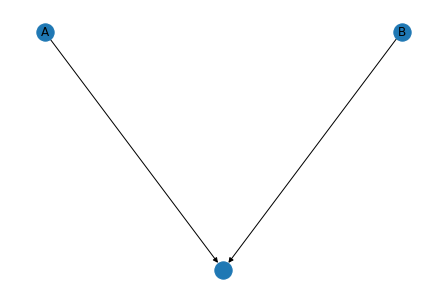

In [46]:
# Save labeled graph image
data_gen.graph.visualize(labels={A: "A", B: "B"})
plt.savefig(f"{TRIAL_ID}.graph.png")

In [47]:
# Set up optimizers
inner_lr = 1e-1 #1e-1
outer_lr = 1e-2

#optimizer = torch.optim.SGD(model.modules_parameters(), lr=inner_lr)
#meta_optimizer = torch.optim.RMSprop([model.w], lr=outer_lr)
optimizer = torch.optim.SGD(model.hypothesis_parameters(), lr=inner_lr)
meta_optimizer = torch.optim.RMSprop(model.structure_parameters(), lr=outer_lr)

In [48]:
# Training constants
num_runs = 4 # 10
num_training = 1 # 100
num_transfer = 500
num_gradient_steps = 20

#train_batch_size = 1000
pretrain_batch_size = 1000
transfer_batch_size = 50

In [49]:
alpha_AB = np.zeros((num_runs, num_training, num_transfer))
alpha_BA = np.zeros((num_runs, num_training, num_transfer))
inner_log_likelihood_AB = np.zeros((num_runs, num_training, num_transfer, num_gradient_steps + 1))
inner_log_likelihood_BA = np.zeros((num_runs, num_training, num_transfer, num_gradient_steps + 1))

for j in tnrange(num_runs):
    # Reset structure model parameters
    # model.w.data.zero_()
    model.reset_structure_parameters()
    
    for i in tnrange(num_training, leave=False):
        # Step 1: Sample a joint distribution before intervention
        data_gen.reset_all_distributions()

        # Step 1.5: Save samples to pretrain hypothesis models before each transfer training iteration
        pretrain_samples = data_gen.sample(pretrain_batch_size)
        
        transfers = tnrange(num_transfer, leave=False)
        for k in transfers:
            # Step 2: Pretrain the modules on the training distribution
            model.set_maximum_likelihood(pretrain_samples)

            # Step 3: Sample a joint distribution after intervention
            data_gen.reset_root_distributions()

            # Step 3.5: Log first inner training loss
            '''
            multivar_onehot_samples = data_gen.sample(transfer_batch_size)
            a_inds = torch.argmax(multivar_onehot_samples[:, A, :], dim=-1)
            b_inds = torch.argmax(multivar_onehot_samples[:, B, :], dim=-1)
            x_train = torch.cat([a_inds.reshape(-1, 1), b_inds.reshape(-1, 1)], dim=-1).type(torch.int64)
            with torch.no_grad():
                inner_log_likelihood_AB[j, i, k, 0] = torch.mean(model.model_A_B(x_train)).item()
                inner_log_likelihood_BA[j, i, k, 0] = torch.mean(model.model_B_A(x_train)).item()
            '''
            with torch.no_grad():
                transfer_samples = data_gen.sample(transfer_batch_size)
                inner_log_likelihood_AB[j, i, k, 0] = torch.mean(model.model_A_B(transfer_samples)).item()
                inner_log_likelihood_BA[j, i, k, 0] = torch.mean(model.model_B_A(transfer_samples)).item()

            # Step 4: Do k steps of gradient descent for adaptation on the
            # distribution after intervention
            model.zero_grad()
            loss = torch.tensor(0.)
            for g in range(num_gradient_steps):
                '''
                multivar_onehot_samples = data_gen.sample(transfer_batch_size)
                a_inds = torch.argmax(multivar_onehot_samples[:, A, :], dim=-1)
                b_inds = torch.argmax(multivar_onehot_samples[:, B, :], dim=-1)
                x_train = torch.cat([a_inds.reshape(-1, 1), b_inds.reshape(-1, 1)], dim=-1).type(torch.int64)
                '''
                x_train = data_gen.sample(transfer_batch_size)
                loss += -torch.mean(model(x_train))
                optimizer.zero_grad()
                inner_loss_A_B = -torch.mean(model.model_A_B(x_train))
                inner_loss_B_A = -torch.mean(model.model_B_A(x_train))
                inner_loss = inner_loss_A_B + inner_loss_B_A
                inner_loss.backward()
                optimizer.step()

                # Log inner training loss
                with torch.no_grad():
                    inner_log_likelihood_AB[j, i, k, g + 1] = torch.mean(model.model_A_B(x_train)).item()
                    inner_log_likelihood_BA[j, i, k, g + 1] = torch.mean(model.model_B_A(x_train)).item()


            # Step 5: Update the structural parameter alpha
            meta_optimizer.zero_grad()
            loss.backward()
            meta_optimizer.step()

            # Log the values of alpha
            # alpha = torch.sigmoid(model.w).item()
            alpha_AB[j, i, k] = torch.softmax(model.gamma, dim=0)[0].item()
            alpha_BA[j, i, k] = torch.softmax(model.gamma, dim=0)[1].item()
            # transfers.set_postfix(alpha='{0:.4f}'.format(alpha), grad='{0:.4f}'.format(model.w.grad.item()))
            transfers.set_postfix(alphas='{0:.4f}, {1:.4f}'.format(alpha_AB[j, i, k], alpha_BA[j, i, k]), grad='{0:.4f}, {1:.4f}'.format(model.gamma.grad[0].item(), model.gamma.grad[1].item()))


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

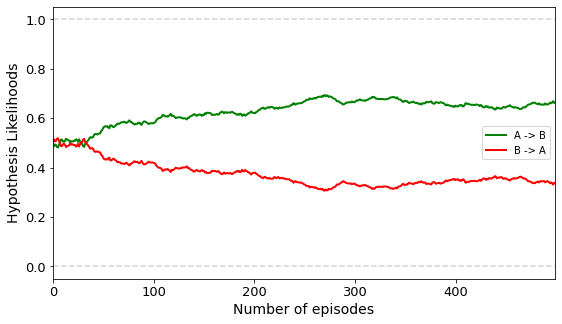

In [52]:
alpha_AB_50 = np.percentile(alpha_AB.reshape((-1, num_transfer)), 50, axis=0)
alpha_BA_50 = np.percentile(alpha_BA.reshape((-1, num_transfer)), 50, axis=0)

fig = plt.figure(figsize=(9, 5))
ax = plt.subplot(1, 1, 1)

ax.tick_params(axis='both', which='major', labelsize=13)
ax.axhline(1, c='lightgray', ls='--')
ax.axhline(0, c='lightgray', ls='--')
ax.plot(alpha_AB_50, lw=2, color='g', label="A -> B")
ax.plot(alpha_BA_50, lw=2, color='r', label="B -> A")
ax.legend()

ax.set_xlim([0, num_transfer - 1])
ax.set_xlabel('Number of episodes', fontsize=14)
ax.set_ylabel("Hypothesis Likelihoods", fontsize=14)

plt.savefig(f"{TRIAL_ID}_median_alphas.png")
plt.show()

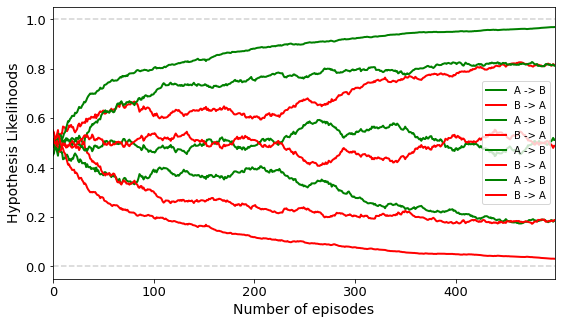

In [53]:
alpha_AB_all = alpha_AB.reshape((-1, num_transfer))
alpha_BA_all = alpha_BA.reshape((-1, num_transfer))

fig = plt.figure(figsize=(9, 5))
ax = plt.subplot(1, 1, 1)

ax.tick_params(axis='both', which='major', labelsize=13)
ax.axhline(1, c='lightgray', ls='--')
ax.axhline(0, c='lightgray', ls='--')

for i in range(alpha_AB_all.shape[0]):
    if i == 0:
        ax.plot(alpha_AB_all[i], lw=2, color='g', label="A -> B")
        ax.plot(alpha_BA_all[i], lw=2, color='r', label="B -> A")
    else:
        ax.plot(alpha_AB_all[i], lw=2, color='g')
        ax.plot(alpha_BA_all[i], lw=2, color='r')
ax.legend()

ax.set_xlim([0, num_transfer - 1])
ax.set_xlabel('Number of episodes', fontsize=14)
ax.set_ylabel("Hypothesis Likelihoods", fontsize=14)

plt.savefig(f"{TRIAL_ID}_all_alphas.png")
plt.show()

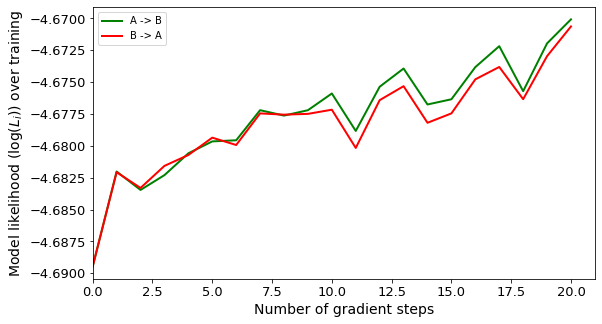

In [51]:
inner_log_likelihood_AB_50 = np.percentile(inner_log_likelihood_AB.reshape(-1, num_gradient_steps + 1), 50, axis=0)
inner_log_likelihood_BA_50 = np.percentile(inner_log_likelihood_BA.reshape(-1, num_gradient_steps + 1), 50, axis=0)

fig = plt.figure(figsize=(9, 5))
ax = plt.subplot(1, 1, 1)

ax.tick_params(axis='both', which='major', labelsize=13)
ax.plot(inner_log_likelihood_AB_50, lw=2, color='g', label=f"A -> B")
ax.plot(inner_log_likelihood_BA_50, lw=2, color='r', label=f"B -> A")
ax.legend()

ax.set_xlim([0, num_gradient_steps + 1])
ax.set_xlabel('Number of gradient steps', fontsize=14)
ax.set_ylabel(r'Model likelihood ($\log(L_i)$) over training', fontsize=14)

plt.savefig(f"{TRIAL_ID}_inner_training.png")
plt.show()